In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display

## Data loading

In [2]:


dfImages = pd.read_csv('../data/IAPS.csv',
                       sep=';',
                       usecols=['IAPS', 'ValenceMean', 'ArousalMean']
                      )



dfSounds = pd.read_csv('../data/IADS2.csv', sep=';', usecols=['Number', 'ValenceMean', 'ArousalMean'])


studyDatafiles = glob.glob('../data/procedura/*.txt')

li = []

for filename in studyDatafiles:
    df = pd.read_csv(filename, sep='\t', header=None, names=['ID', 'nn', 'Condition', 'SpecificCondition', 'Number', 'IAPS', 'Widget', 'Response', 'Delay', 'ApperanceTimestamp'])
    li.append(df)
                         
dfStudy = pd.concat(li, axis=0, ignore_index=True)

dfStudy = dfStudy[dfStudy.Condition != 'con']
dfStudy = dfStudy[dfStudy.Widget != 'emoscale1']
                                     


## Preprocessing

In [3]:


dfStudy['Number'] = pd.to_numeric(dfStudy['Number'])



def convertResponseStringIntoColumns(string):
    string = string[1:-1]
    array = (string.split(','))
    array[0] = (float(array[0]) * 4) + 5
    array[1] = (float(array[1][1:]) * 4) + 5
    return array

def findExpectedImageReaction(iaps):
    valence = dfImages[dfImages.IAPS == str(iaps)].ValenceMean.tolist()
    arousal = dfImages[dfImages.IAPS == str(iaps)].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def findExpectedSoundReaction(number):
    valence = dfSounds[dfSounds.Number == number].ValenceMean.tolist()
    arousal = dfSounds[dfSounds.Number == number].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def applySpecificCondition(condition, i):
    if (condition[1] == '-' and i == 0) or (condition[3] == '-' and i == 1):
        return -1
    else:
        return 1

def labelReaction(valence):
    return 1 if valence < 0 else -1

    
def getValence(array):
    return array[0]

def getArousal(array):
    return array[1]
    
dfStudy['ActualReaction'] = dfStudy.Response.apply(func = convertResponseStringIntoColumns)

dfStudy['ExpectedImageReaction'] = dfStudy.IAPS.apply(findExpectedImageReaction)
dfStudy['ExpectedSoundReaction'] = dfStudy.Number.apply(findExpectedSoundReaction)
       
dfStudy['ImageCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 0)
dfStudy['SoundCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 1)

dfStudy['ImageValence'] = dfStudy.ExpectedImageReaction.apply(getValence)
dfStudy['ImageArousal'] = dfStudy.ExpectedImageReaction.apply(getArousal)
dfStudy['SoundValence'] = dfStudy.ExpectedSoundReaction.apply(getValence)
dfStudy['SoundArousal'] = dfStudy.ExpectedSoundReaction.apply(getArousal)
dfStudy['ActualValence'] = dfStudy.ActualReaction.apply(getValence)
dfStudy['ActualArousal'] = dfStudy.ActualReaction.apply(getArousal)
dfStudy['Label'] = dfStudy.ActualValence.apply(labelReaction)

df = dfStudy[['ImageCondition',
              'ImageValence',
              'ImageArousal',
              'SoundCondition',
              'SoundValence',
              'SoundArousal',
              'ActualValence',
              'ActualArousal',
              'Label'
             ]]
df = df.dropna()
df.head()


,ImageCondition,ImageValence,ImageArousal,SoundCondition,SoundValence,SoundArousal,ActualValence,ActualArousal,Label
0,-1,1.91,5.60,1,6.47,7.32,5.337471,5.629460,-1
3,1,6.27,6.06,-1,2.04,6.87,3.273110,5.770667,-1
4,1,5.89,6.21,-1,1.63,7.79,4.691487,6.091272,-1
6,1,6.44,7.07,-1,2.22,7.52,5.034287,6.560032,-1
7,1,6.22,6.62,-1,1.65,7.61,3.798088,6.452520,-1


## Regression Model



In [4]:


x = df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']]
    
y = df[['Label']]

reg = LinearRegression(n_jobs=-1)
X = np.array(x)
Y =  np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9)
reg.fit(X_train, Y_train)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label')
print(reg.score(X_test, Y_test))
print(reg.coef_)


      






Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label
1.0
[[0. 0. 0. 0. 0. 0.]]


In [5]:


reg = LinearRegression(n_jobs=-1)

      
X = df[['ImageValence',
        'SoundValence']]
Y = df['ActualValence']
reg.fit(X, Y)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X, Y))
print(reg.coef_)


      
X = df[['ImageArousal',
        'SoundArousal']]
Y = df['ActualArousal']
reg.fit(X, Y)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X, Y))
print(reg.coef_)





ImageValence SoundValence || ActualValence
0.19550875745051655
[0.65427463 0.44793881]
ImageArousal SoundArousal || ActualArousal
0.014775004819475246
[0.23082689 0.27884308]


In [6]:


reg = LinearRegression(n_jobs=-1)

X = np.array(df[['ImageValence',
        'SoundValence']])
X = preprocessing.scale(X)
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X_test, Y_test))
print(reg.coef_)



X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X_test, Y_test))
print(reg.coef_)





ImageValence SoundValence || ActualValence
0.20422710445852843
[1.53212277 0.94701886]
ImageArousal SoundArousal || ActualArousal
0.010248711887454576
[0.21308135 0.30174009]


In [7]:


reg = svm.SVR(kernel='poly', gamma='scale')

X = np.array(df[['ImageValence',
        'SoundValence']])
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X_test, Y_test))


      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X_test, Y_test))





ImageValence SoundValence || ActualValence
0.169582264938001
ImageArousal SoundArousal || ActualArousal
-8.585691278523592


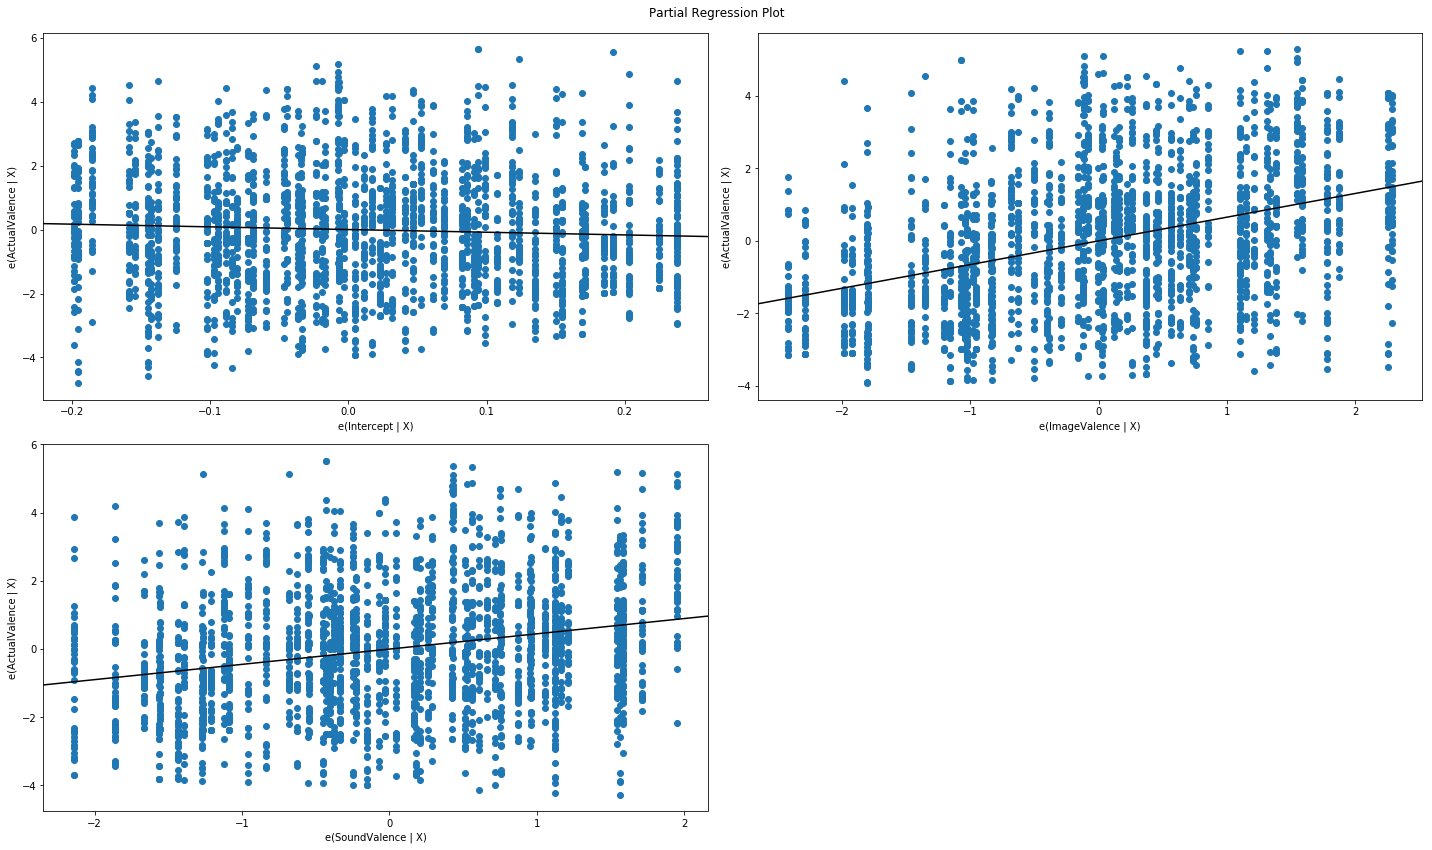

In [8]:
olsModel = ols("""ActualValence ~ ImageValence + SoundValence""", data=df).fit()

HTML(olsModel.summary().as_html())

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

HTML(olsModel.summary().as_html())


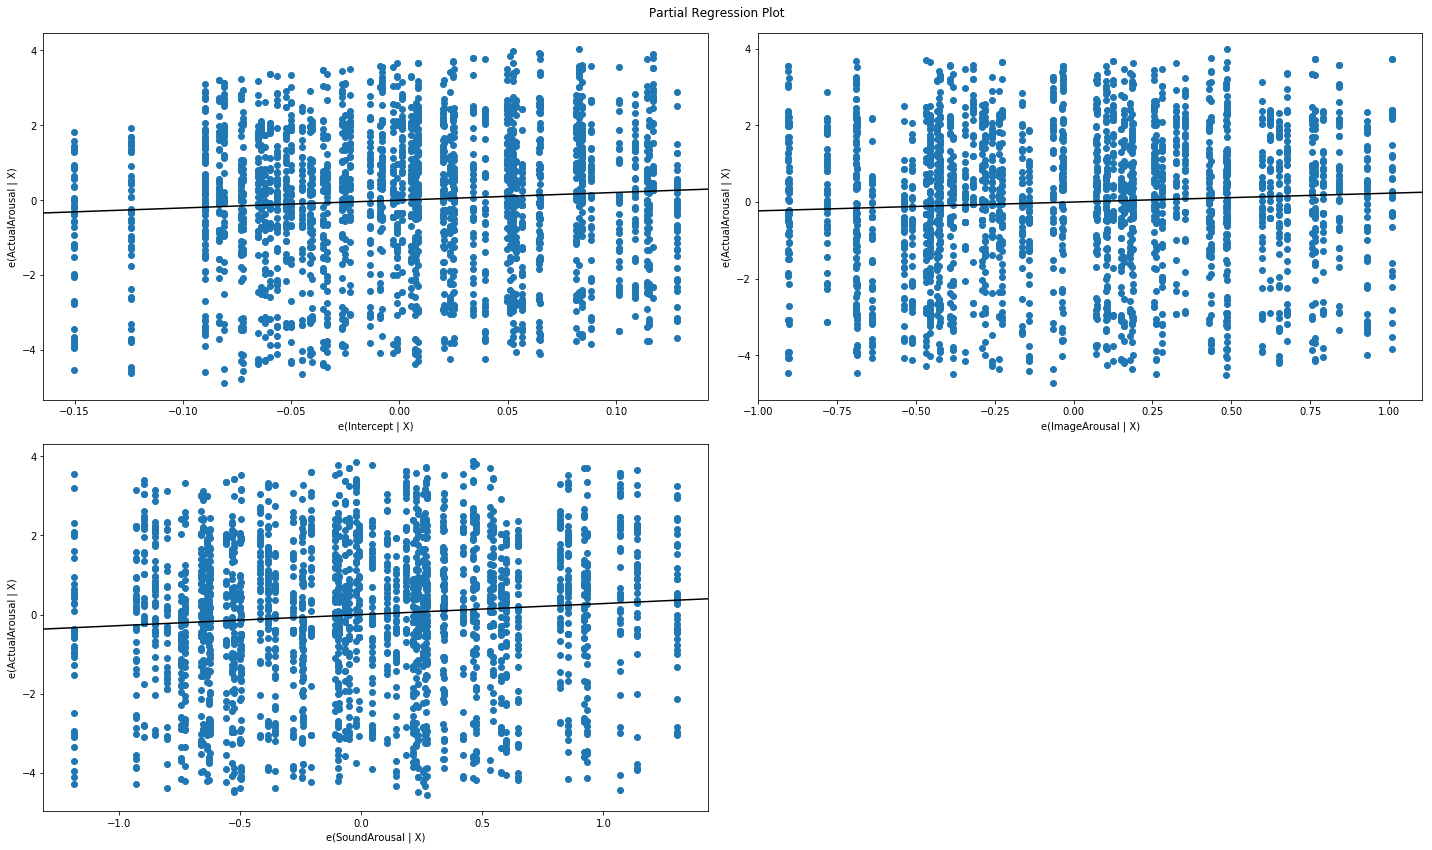

In [9]:
olsModel = ols("""ActualArousal ~ ImageArousal + SoundArousal""", data=df).fit()

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)

HTML(olsModel.summary().as_html())


/home/axl/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
